# STEP 1: Import Libraries

In [140]:
# STEP 1: Import Libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
!pip install xgboost
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

# STEP 2: Define File Paths

In [141]:
# STEP 2: Define File Paths

data_root = "/Users/seidana/Desktop/widsdatathon2025-university (1)"

# ✅ This matches what you saw in the scan:
# /Users/.../train_tsv/train_tsv/sub-XXXX....tsv
train_dir = os.path.join(data_root, "train_tsv", "train_tsv")

# If your test data has the same structure, this is probably right:
test_dir = os.path.join(data_root, "test_tsv", "test_tsv")

metadata_path = os.path.join(data_root, "metadata", "training_metadata.csv")
test_metadata_path = os.path.join(data_root, "metadata", "test_metadata.csv")

print("Train dir:", train_dir)
print("Test dir:", test_dir)
print("Metadata path:", metadata_path)
print("Test metadata path:", test_metadata_path)

Train dir: /Users/seidana/Desktop/widsdatathon2025-university (1)/train_tsv/train_tsv
Test dir: /Users/seidana/Desktop/widsdatathon2025-university (1)/test_tsv/test_tsv
Metadata path: /Users/seidana/Desktop/widsdatathon2025-university (1)/metadata/training_metadata.csv
Test metadata path: /Users/seidana/Desktop/widsdatathon2025-university (1)/metadata/test_metadata.csv


# STEP 3: Load and Flattten fMRI Correlation Matrices

In [142]:
# STEP 3: Load and Flatten fMRI Correlation Matrices

print("🔎 Using train_dir:", train_dir)
print("   Exists?        :", os.path.exists(train_dir))
print("   Contents (first 5):")
for name in os.listdir(train_dir)[:5]:
    print("  -", name)

# Get all .tsv files directly inside train_dir
tsv_files = [f for f in os.listdir(train_dir) if f.endswith(".tsv")]
print(f"📂 Found {len(tsv_files)} .tsv files in train_dir")

if len(tsv_files) == 0:
    raise RuntimeError(
        f"No .tsv files found directly in {train_dir}. "
        "Make sure this folder directly contains the sub-XXXX...correlations.tsv files."
    )

all_features = []
all_ids = []

print("🔄 Processing training .tsv files...")
for filename in tqdm(tsv_files):
    filepath = os.path.join(train_dir, filename)

    # Load correlation matrix
    df = pd.read_csv(filepath, sep='\t', index_col=0)
    fc_matrix = df.values

    # Flatten the upper triangle (excluding diagonal)
    upper_tri = fc_matrix[np.triu_indices_from(fc_matrix, k=1)]
    all_features.append(upper_tri)

    # Extract subject ID from filename, e.g. 'sub-NDARAA306NT2_...'
    sub_id = filename.split("_")[0].replace("sub-", "")
    all_ids.append(sub_id)

# Stack all subject features into one big feature matrix
X = np.vstack(all_features)
print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Number of subjects:  {len(all_ids)}")

🔎 Using train_dir: /Users/seidana/Desktop/widsdatathon2025-university (1)/train_tsv/train_tsv
   Exists?        : True
   Contents (first 5):
  - sub-NDAREE015WGU_ses-HBNsiteCBIC_task-rest_run-1_atlas-Schaefer2018p200n17_space-MNI152NLin6ASym_reg-36Parameter_desc-PearsonNilearn_correlations.tsv
  - sub-NDARNV694EMG_ses-HBNsiteRU_task-rest_run-1_atlas-Schaefer2018p200n17_space-MNI152NLin6ASym_reg-36Parameter_desc-PearsonNilearn_correlations.tsv
  - sub-NDARFR108JNB_ses-HBNsiteRU_task-rest_run-2_atlas-Schaefer2018p200n17_space-MNI152NLin6ASym_reg-36Parameter_desc-PearsonNilearn_correlations.tsv
  - sub-NDARZF170TZ0_ses-HBNsiteCBIC_task-rest_run-2_atlas-Schaefer2018p200n17_space-MNI152NLin6ASym_reg-36Parameter_desc-PearsonNilearn_correlations.tsv
  - sub-NDARYJ334EHH_ses-HBNsiteRU_task-rest_run-2_atlas-Schaefer2018p200n17_space-MNI152NLin6ASym_reg-36Parameter_desc-PearsonNilearn_correlations.tsv
📂 Found 1104 .tsv files in train_dir
🔄 Processing training .tsv files...


100%|██████████████████████████████████████| 1104/1104 [00:06<00:00, 158.31it/s]

✅ Feature matrix shape: (1104, 19701)
✅ Number of subjects:  1104


# STEP 4: Helper Function - Extract upper triangle

In [143]:
# STEP 4: Helper Function - Extract upper triangle
def extract_upper_triangle(file_path):
    matrix = pd.read_csv(file_path, sep='\t', header=None).values
    upper_tri_indices = np.triu_indices_from(matrix, k=1)
    return matrix[upper_tri_indices]

# STEP 5: Load and Process Training Data

In [144]:
# STEP 5: Load and Process Training Data

train_vectors, train_ids = [], []

print("🔄 Processing training files...")
tsv_files = [f for f in os.listdir(train_dir) if f.endswith(".tsv")]
print(f"📂 Found {len(tsv_files)} .tsv files in {train_dir}")

if len(tsv_files) == 0:
    raise RuntimeError(
        f"No .tsv files found directly in {train_dir}. "
        "Make sure this folder directly contains the sub-XXXX...correlations.tsv files."
    )

for filename in tqdm(tsv_files):
    filepath = os.path.join(train_dir, filename)

    # extract participant ID, e.g. 'sub-NDARAA306NT2_...' -> 'NDARAA306NT2'
    participant_id = filename.split("_")[0].replace("sub-", "")

    # extract flattened upper triangle from correlation matrix
    vector = extract_upper_triangle(filepath)

    train_vectors.append(vector)
    train_ids.append(participant_id)

# put into DataFrame: one row per subject
X_train_raw = pd.DataFrame(train_vectors)
X_train_raw["participant_id"] = train_ids

print("✅ Raw feature matrix shape:", X_train_raw.shape)

🔄 Processing training files...
📂 Found 1104 .tsv files in /Users/seidana/Desktop/widsdatathon2025-university (1)/train_tsv/train_tsv


100%|██████████████████████████████████████| 1104/1104 [00:06<00:00, 159.62it/s]


✅ Raw feature matrix shape: (1104, 19901)


# STEP 6: Load and Merge Metadata

In [145]:
# STEP 6: Load and Merge Metadata + Create X, y

# Load metadata
metadata = pd.read_csv(metadata_path)

# Clean up IDs to be safe
X_train_raw["participant_id"] = X_train_raw["participant_id"].astype(str).str.upper().str.strip()
metadata["participant_id"] = metadata["participant_id"].astype(str).str.upper().str.strip()

# Merge on participant_id
train_df = pd.merge(X_train_raw, metadata, on="participant_id")
print("✅ Merged training data shape:", train_df.shape)

# ---- Build X and y for modeling ----

# All brain-feature columns are the numeric ones from the flattened upper triangle
brain_cols = [col for col in train_df.columns if isinstance(col, int) or (isinstance(col, str) and col.isdigit())]

# 🎯 Target column: predicting age
TARGET_COLUMN = "age"   # <- change this if you want a different target

X = train_df[brain_cols].values
y = train_df[TARGET_COLUMN].values

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)

✅ Merged training data shape: (1104, 19914)
✅ X shape: (1104, 19900)
✅ y shape: (1104,)


# STEP 7: Clean Modeling Pipeline

In [146]:
# Step 7: Clean Modeling Pipeline (No Leakage)

# 1) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

# 2) Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3) PCA for dimensionality reduction
pca = PCA(n_components=100, random_state=42)  # you can tune this number
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print("Train PCA shape:", X_train_pca.shape, "Val PCA shape:", X_val_pca.shape)

# 4) Ridge regression model
model = Ridge(alpha=1.0, random_state=42)  # you can tune alpha too
model.fit(X_train_pca, y_train)

# 5) Evaluate
y_pred = model.predict(X_val_pca)

r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

print("📊 Validation Metrics:")
print(f"R² Score:  {r2:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"MAE:       {mae:.4f}")

Train shape: (883, 19900) Val shape: (221, 19900)
Train PCA shape: (883, 100) Val PCA shape: (221, 100)
📊 Validation Metrics:
R² Score:  0.5570
RMSE:      2.0933
MSE:       4.3819
MAE:       1.6481


# STEP 8: Visualize Model Performance

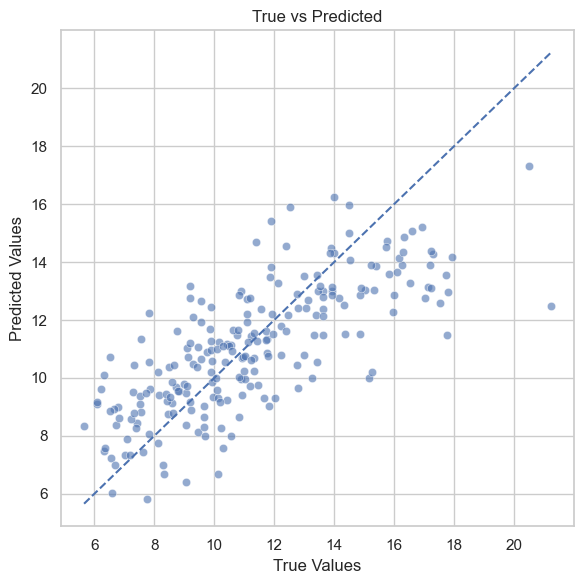

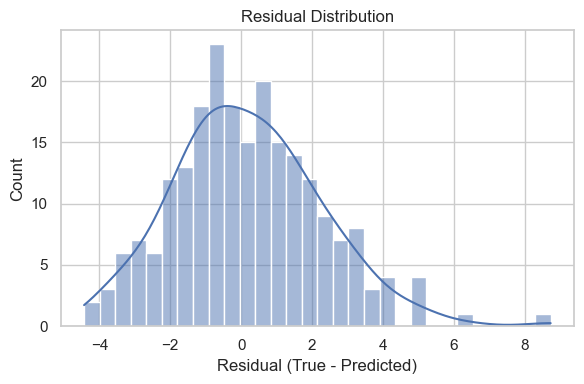

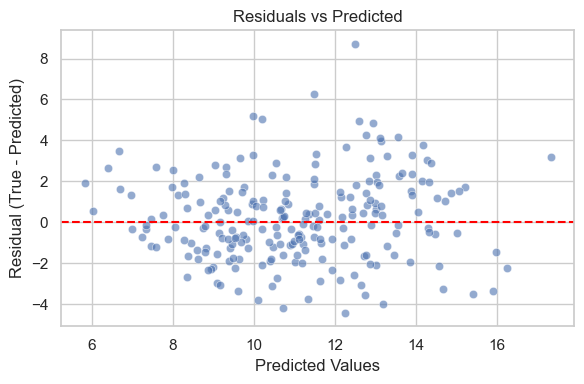

In [147]:
# STEP 8: Visualize Model Performance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure we're using arrays
y_true = np.array(y_val)
y_predicted = np.array(y_pred)

# 1) Scatter plot: True vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_predicted, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Residuals = True - Predicted
residuals = y_true - y_predicted

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Residuals vs Predicted (check for patterns)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_predicted, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

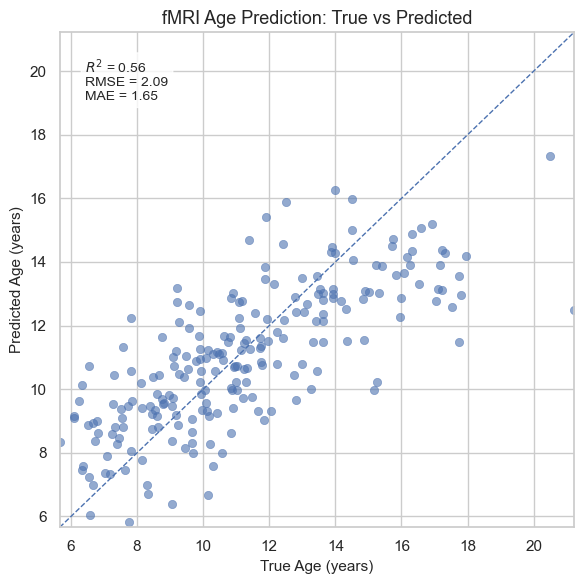

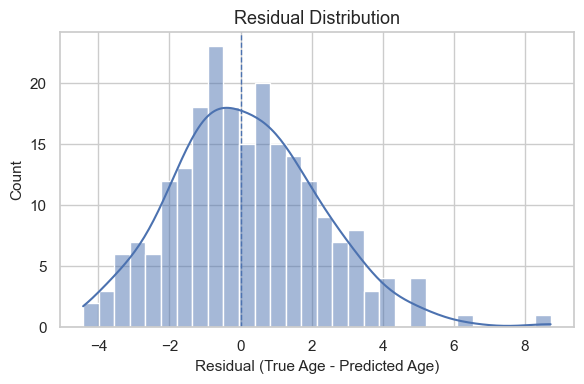

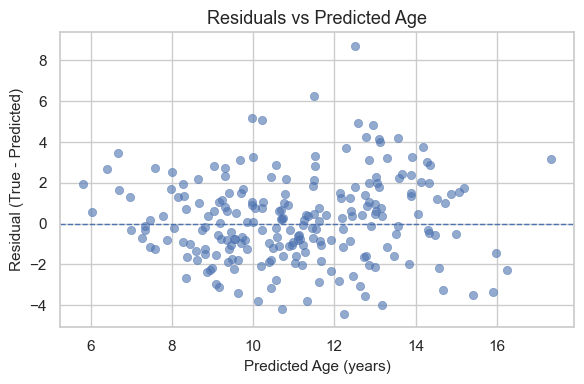

In [148]:
# Improved visualizations for fMRI age prediction

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean style
sns.set_theme(style="whitegrid")

# Make sure these exist from your previous cell:
# y_val, y_pred, r2, rmse, mae

y_true = np.array(y_val)
y_predicted = np.array(y_pred)
fig.savefig("fmri_age_true_vs_pred_portfolio.png", dpi=300, bbox_inches="tight")
fig.savefig("fmri_age_residuals_hist_portfolio.png", dpi=300, bbox_inches="tight")
fig.savefig("fmri_age_residuals_vs_pred_portfolio.png", dpi=300, bbox_inches="tight")
residuals = y_true - y_predicted

# -------------------------------
# 1) True vs Predicted Age (publication / portfolio ready)
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter
sns.scatterplot(x=y_true, y=y_predicted, ax=ax, alpha=0.6, edgecolor=None)

# Identity line y = x
min_val = min(y_true.min(), y_predicted.min())
max_val = max(y_true.max(), y_predicted.max())
ax.plot([min_val, max_val], [min_val, max_val],
        linestyle="--", linewidth=1)

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

ax.set_xlabel("True Age (years)", fontsize=11)
ax.set_ylabel("Predicted Age (years)", fontsize=11)
ax.set_title("fMRI Age Prediction: True vs Predicted", fontsize=13)

# Add metrics as a small annotation box
text_str = f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}"
ax.text(
    0.05, 0.95,
    text_str,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# Save high-res version for your website
fig.savefig("fmri_age_true_vs_pred_portfolio.png", dpi=300, bbox_inches="tight")

# -------------------------------
# 2) Residual Distribution
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(residuals, bins=30, kde=True, ax=ax)
ax.axvline(0, linestyle="--", linewidth=1)

ax.set_xlabel("Residual (True Age - Predicted Age)", fontsize=11)
ax.set_ylabel("Count", fontsize=11)
ax.set_title("Residual Distribution", fontsize=13)

plt.tight_layout()
plt.show()

fig.savefig("fmri_age_residuals_hist_portfolio.png", dpi=300, bbox_inches="tight")

# -------------------------------
# 3) Residuals vs Predicted Age
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(x=y_predicted, y=residuals, ax=ax, alpha=0.6, edgecolor=None)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_xlabel("Predicted Age (years)", fontsize=11)
ax.set_ylabel("Residual (True - Predicted)", fontsize=11)
ax.set_title("Residuals vs Predicted Age", fontsize=13)

plt.tight_layout()
plt.show()

fig.savefig("fmri_age_residuals_vs_pred_portfolio.png", dpi=300, bbox_inches="tight")

In [149]:
print(os.getcwd())

/Users/seidana/Downloads
